In [1]:
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from netCDF4 import Dataset
import urllib.request

In [2]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

cluster = SLURMCluster(
    cores=4,
    memory='15GB',
    walltime='01:00:00',
    queue='compute',
    interface='ib0', 
    job_extra_directives=["--reservation poworkshop"])
cluster.scale(jobs=1)
client = Client(cluster)
client

/vortexfs1/home/anthony.meza/miniforge3/envs/hpc_tutorial/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40884 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/40884/status,
Dashboard: /proxy/40884/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.52:45394,Workers: 0
Dashboard: /proxy/40884/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read in ERA5 Data

In [7]:
era5_data_path = lambda x: "/vortexfs1/share/cmip6/data/era5/reanalysis/single-levels/monthly-means/" + x

def preprocess(ds): 
    
    #take data from monthly -> yearly 
    return  ds.resample(time = "YE").mean()
    
#read 10m u-wind
u10m = xr.open_mfdataset(era5_data_path("10m_u_component_of_wind/*.nc"), 
                         engine = "netcdf4", preprocess = preprocess)
v10m = xr.open_mfdataset(era5_data_path("10m_v_component_of_wind/*.nc"), 
                         engine = "netcdf4", preprocess = preprocess)

wind_ds = xr.merge([u10m, v10m], compat = "minimal")

wind_ds["speed"] = np.sqrt(wind_ds["u10"]**2 + wind_ds["v10"]**2)

sfc_pressure = xr.open_mfdataset(era5_data_path("surface_pressure/*.nc"), 
                                 engine = "netcdf4", preprocess = preprocess)
#get dataset overview

## Correlate pressure and wind data 

In [10]:
#correlate surface pressure and wind speed 
pressure_wind_correlations = xr.corr(sfc_pressure["sp"], wind_ds["speed"], dim = "time")
pressure_wind_correlations = pressure_wind_correlations.compute()
#compute correlation

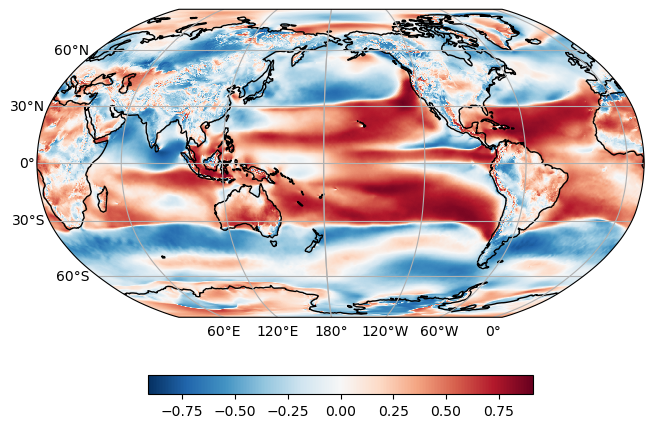

In [14]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})

#plot coastlines
ax.coastlines()
#add gridlines
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True)
#remove top and right labels
gl.top_labels = False
# plot pressure wind correlations
pressure_wind_correlations.plot(ax=ax, transform = ccrs.PlateCarree(), 
                                cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05))

## Select a location to analyze

In [22]:
ds_locs = xr.Dataset()

ds_locs["lon"] = xr.DataArray(data=[-120], dims=("locations")) #select a longitude
 
ds_locs["lat"] = xr.DataArray(data=[-20], dims=("locations"))  #select a latitude

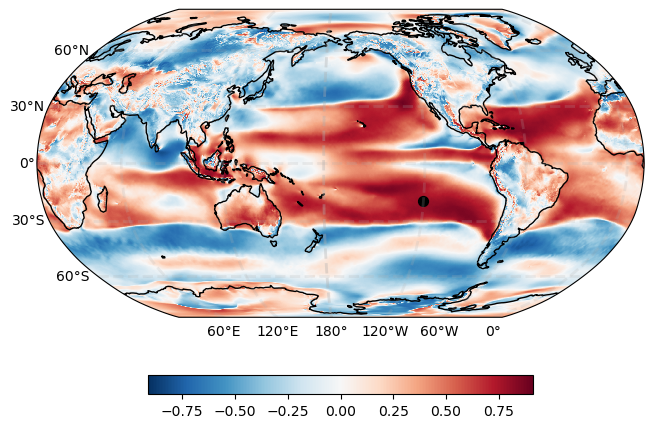

In [23]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()

#plot correlation again 
pressure_wind_correlations.plot(ax=ax, transform = ccrs.PlateCarree(), 
                               cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05))

#plot the point
ax.scatter(ds_locs["lon"], ds_locs["lat"], transform = ccrs.PlateCarree(), s = 50, c = "k")


## Interpolate fields to spot

In [24]:
#create regridder
import xesmf as xe
regridder = xe.Regridder(wind_ds, ds_locs, "bilinear", locstream_out=True) 

#interpolate both datasets

regrid_winds_ds = regridder(wind_ds).compute()
regrid_pressure_ds = regridder(sfc_pressure).compute()

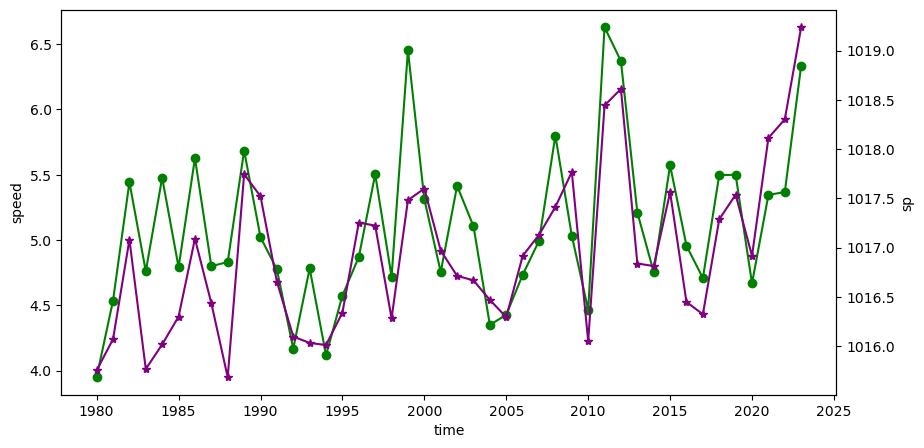

In [26]:
#plot interpolated datasets
fig, ax = plt.subplots(figsize = (10, 5))

wind_speed = regrid_winds_ds["speed"]
surface_pressure = regrid_pressure_ds["sp"] / 100 #conversion: 100 Pa  = 1 millibar

#plot wind speed (choose color)
wind_speed.plot(ax = ax, c = "green", marker = "o")
#plot surface pressure using a second y-axis (choose color)
ax2 = ax.twinx()
surface_pressure.plot(ax = ax2, c = "purple", marker = "*")